# Итоговый проект

Нужно реализовать rest api на базе flask в google colab.

1. выбрать себе датасет (который интересен или нравится больше всего, можно глянуть здесь https://economic-caper-a4c.notion.site/d062c410b90145bca90fc23b1348c813), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
2. Реализовать ноутбук с сервером
3. Реализовать ноутбук с клиентом

## 1. Установка необходимых библиотек

In [ ]:
!pip install dill

In [ ]:
import pandas as pd
import numpy as np
import dill

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss, ConfusionMatrixDisplay

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

#imputer
from sklearn.impute import SimpleImputer

 ## 2. Загрузка и подготовка данных

Загрузим данные датасета: https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate

Датасет предполагает прогнозирование рейтинга вопроса в классификации:
- HQ: High-quality posts without a single edit.
- LQ_EDIT: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
- LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.

Можно скачать датасет напрямую с кагла, но для этого необходимо получить Kaggle API Token, загрузить файл с токеном на Google Colab и запустить код ниже:

In [ ]:
# !pip install kaggle

In [ ]:
# !mkdir ~/.kaggle
# !cp ./kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download imoore/60k-stack-overflow-questions-with-quality-rate

In [ ]:
# !unzip *.zip

Иначе можно скачать отсюда:

https://drive.google.com/file/d/1CIu_iKXPmXdOPduBHWZKWQzjng4FXAil/view?usp=sharing

И загрузить на Google Colab

In [ ]:
df = pd.read_csv('./train.csv')
df.head(5)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [ ]:
df['Y'].value_counts()

LQ_CLOSE    15000
HQ          15000
LQ_EDIT     15000
Name: Y, dtype: int64

In [ ]:
# Можно перевести категории качества комментариев в численный вид
# df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Y'], test_size=0.33, random_state=42)
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

## 3. Создадим пайплайн

Пайплайн будет заполнять пустые строки в столбцах и взвешивать данные с помощью TfIdf.

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

In [ ]:
features = ['Title', 'Body', 'Tags']
target = 'Y'

In [ ]:
title = Pipeline([
                ('imputer', TextImputer('Title', '')),
                ('selector', ColumnSelector(key='Title')),
                ('tfidf', TfidfVectorizer())
            ])

body = Pipeline([
                ('imputer', TextImputer('Body', '')),
                ('selector', ColumnSelector(key='Body')),
                ('tfidf', TfidfVectorizer())
            ])

tags = Pipeline([
                ('imputer', TextImputer('Tags', '')),
                ('selector', ColumnSelector(key='Tags')),
                ('tfidf', TfidfVectorizer())
            ])


feats = FeatureUnion([('Title', title),
                      ('Body', body),
                      ('Tags', tags)])

## 4. Обучим Случайный лес на тренировочной выборке

In [ ]:
%%time

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier()),
])

pipeline.fit(X_train, y_train)

CPU times: user 3min 13s, sys: 453 ms, total: 3min 14s
Wall time: 3min 20s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Title',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Title',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('Body',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Body',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Body')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('Tags',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Tags',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Tags')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('classifier', RandomForestClassifier())])

In [ ]:
pipeline.steps

[('features',
  FeatureUnion(transformer_list=[('Title',
                                  Pipeline(steps=[('imputer',
                                                   TextImputer(key='Title',
                                                               value='')),
                                                  ('selector',
                                                   ColumnSelector(key='Title')),
                                                  ('tfidf', TfidfVectorizer())])),
                                 ('Body',
                                  Pipeline(steps=[('imputer',
                                                   TextImputer(key='Body',
                                                               value='')),
                                                  ('selector',
                                                   ColumnSelector(key='Body')),
                                                  ('tfidf', TfidfVectorizer())])),
                       

In [ ]:
# сохраняем пайплайн в формате dill
with open("rfc_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

## 5. Проверка работоспособности и качества пайплайна

In [ ]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
X_test.head(3)

,Id,Title,Body,Tags,CreationDate,Y
0,54233203,not able to run function in php,<p>I'am not able to run a function in php oops...,<php><oop>,2019-01-17 09:54:10,LQ_CLOSE
1,39253307,Export GIT LOG into an Excel file,"<p>I have looked into the forum, but with no l...",<git><logging>,2016-08-31 15:13:57,HQ
2,58793066,How to summarize the employees by net revenue ...,8.\tThe sales director would like to reward th...,<sql>,2019-11-10 21:25:11,LQ_EDIT


In [ ]:
# загружаем, созданный ранее, пайплайн
with open('rfc_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [ ]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Title',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Title',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('Body',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Body',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Body')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('Tags',
                                                 Pipeline(steps=[('imputer',
                                                                  TextImputer(key='Tags',
                                                                              value='')),
                                                                 ('selector',
                                                                  ColumnSelector(key='Tags')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('classifier', RandomForestClassifier())])

Делаем предсказания на тестовой выборке:

In [ ]:
# preds = pipeline.predict_proba(X_test)[:, 1]
preds = pipeline.predict(X_test)
pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

In [ ]:
preds[:10]

array(['LQ_CLOSE', 'HQ', 'LQ_EDIT', 'LQ_CLOSE', 'LQ_EDIT', 'LQ_CLOSE',
       'HQ', 'HQ', 'LQ_EDIT', 'LQ_CLOSE'], dtype=object)

## 6. Проверяем метрики качества модели

In [ ]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# считаем метрику точности
test_accuracy = accuracy_metric(np.array(y_test), preds)
test_accuracy

79.25925925925927

In [ ]:
rf_test_accuracy = pipeline.score(X_test, y_test)
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_test_accuracy)*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 79.26%


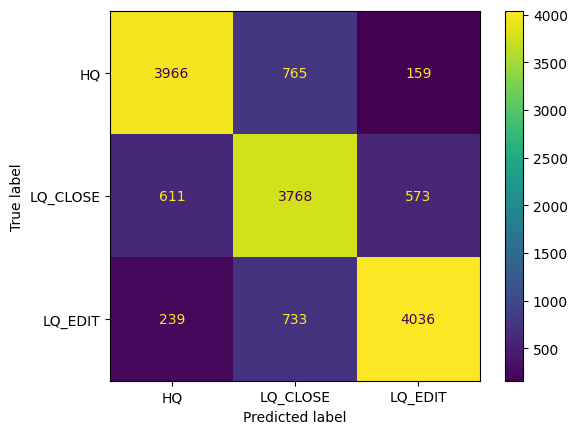

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

## 7. Подгружаем библиотеки для FLASK

In [ ]:
!pip install flask-ngrok # строка для google colab

In [ ]:
from flask_ngrok import run_with_ngrok # строка для google colab
from flask import Flask, request, jsonify

https://dashboard.ngrok.com/get-started/setup

In [ ]:
# пункт для google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 25vEpcJ5Ih4vlUp4thEZ9sEA6ZU_3Bnu17gKacRXhF6hLeefc
# !./ngrok http 80

--2023-09-19 14:16:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.1’

ngrok-stable-linux- 100%[===================>]  13.21M  87.2MB/s    in 0.2s    

2023-09-19 14:16:10 (87.2 MB/s) - ‘ngrok-stable-linux-amd64.tgz.1’ saved [13856790/13856790]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# Загружаем обученные модели
with open('rfc_pipeline.dill', 'rb') as in_strm:
    model = dill.load(in_strm)

## 8. Запуск сервера Flask, на котором будет работать наша обученая модель

При работе через Google colab, при создании сервера каждый раз будет генерироваться новый url с разными цифрами формата: http://5849-35-225-82-181.ngrok-free.app . Его нужно будет скопировать и вставить в код клиентской части.

In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # строка для google colab


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    title, body, tags = "", "", ""
    request_json = request.get_json()

    if request_json["Title"]:
        title = request_json['Title']

    if request_json["Body"]:
        body = request_json['Body']

    if request_json["Tags"]:
        tags = request_json['Tags']

    print(title)
    preds = model.predict(pd.DataFrame({"Title": [title], "Body": [body], "Tags": [tags]}))
    data["Predictions"] = preds[0]
    data["Title"] = title
    data["Body"] = body

    # индикатор, что запрос прошел удачно
    data["success"] = True
    print('OK')

    # возвращаем данные в виде словаря в формате JSON
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://83e9-35-236-240-147.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:46] "POST /predict HTTP/1.1" 200 -


How to get all the child records from 
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
How to get all the child records from different tables based on given parent ID in sql server
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -


Retrieve all except some data of the another table
OK
Pandas: read_html
OK
Reader Always gimme NULL


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:47] "POST /predict HTTP/1.1" 200 -


OK
php rearrange array elements based on condition
OK
How do I make a constructor for a derived class?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -


how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -


OK
Print list content in a given order
OK
c# - List all primes upto 100
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -


Angular2 exception: Token must be defined
OK
Form Validation project
OK
Most Pythonic way to kill a thread after some period of time


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -


OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -


Django ImageField upload_to path
OK
Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -


OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK
I cant UPDATE datetime to MySQL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -


How to correctly share JAX-RS 2.0 client
OK
argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -


OK
In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -


React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))
OK
Turn Android into USB host


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -


OK
I want to insert a couple of sentences into an array
OK
Elasticsearch Bulk API - Index vs Create/Update
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -


SockJS Python Client
OK
Simple console graphics in C
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -


Hover effect is backward from image. How hover effect can be forward from image?
OK
I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -


OK
Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -


Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -


OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -


Cannot find alphabet symbol
OK
What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -


OK
Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -


Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK
Get the enclosing class of a Java lambda expression


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -


OK
how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -


OK
What are typescript typings?
OK
Text to morse code using jQuery
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:52] "POST /predict HTTP/1.1" 200 -


What does compound let/const assignment mean?
OK
C# send string array over socket
OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -


OK
Which regex should I use?
OK
CLI 400 error deploying to Google App Engine
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -


Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -


OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:53] "POST /predict HTTP/1.1" 200 -


I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -


OK
Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -


OK
How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -


OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -


OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK
What is ".v8flags.3.14.5.9.{Name}"?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -


OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -


OK
How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -


OK
Generate a Stripe test card token for testing
OK
Swap position of number in a 4 digit number without array


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -


OK
Docker: what is the equivalent of the legacy --link parameter
OK
DateDiff use current date if enddate is null


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:55] "POST /predict HTTP/1.1" 200 -


OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK
What kind of Cloud do I need?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -


OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK
Configure proxy settings in Notepad++ via Plugin Manager


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -


OK
IOException -> number format exception
OK
Structures in C, keytab program
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -


How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:56] "POST /predict HTTP/1.1" 200 -


Use of class/struct to store info in R
OK
how to condense a string of numbers
OK
Why are Comma's being printed?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:57] "POST /predict HTTP/1.1" 200 -


Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK
Upcasting in java for non primitive types


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:16:57] "POST /predict HTTP/1.1" 200 -


OK
Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK
Pandas: read_html


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -


OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -


How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -


OK
Fetch API with Cookie
OK
Print list content in a given order
OK

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -



c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -


Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -



OK
Filter Name with Starting Letter in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -


Django ImageField upload_to path
OK
Compiling SASS in Windows 7
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:15] "POST /predict HTTP/1.1" 200 -


to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -


I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -


argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -


In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -


React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -


Turn Android into USB host
OK
I want to insert a couple of sentences into an array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -


Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -


Simple console graphics in C
OK
Hover effect is backward from image. How hover effect can be forward from image?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -


I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -


Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage
OK
Does return ends function if ifelse is used?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -


OK
Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -


Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva
OK
Cannot find alphabet symbol


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -


OK
What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -


OK
Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -


OK
Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -


Get the enclosing class of a Java lambda expression
OK
how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -


OK
What are typescript typings?
OK
Text to morse code using jQuery


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -


OK
What does compound let/const assignment mean?
OK
C# send string array over socket
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:19] "POST /predict HTTP/1.1" 200 -


Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK
Which regex should I use?
OK
CLI 400 error deploying to Google App Engine


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -


OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK
How can I add new elements to an array inside of another struct array in C?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -


i want to get the keys and values of each set using java
OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -


OK
I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:20] "POST /predict HTTP/1.1" 200 -


OK
Magento Error :There has been an error processing your request ?
OK
Create a post activate script in Conda
OK

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -



How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK
How to modify SDK manger path?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -


OK
How do you add a Root element/Tag in XML using perl
OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -


OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -


What is ".v8flags.3.14.5.9.{Name}"?
OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -


OK
How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -


Generate a Stripe test card token for testing
OK
Swap position of number in a 4 digit number without array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -


Docker: what is the equivalent of the legacy --link parameter
OK
DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -


OK
What kind of Cloud do I need?
OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -


Configure proxy settings in Notepad++ via Plugin Manager
OK
IOException -> number format exception
OK
Structures in C, keytab program


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -


OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -


OK
Use of class/struct to store info in R
OK
how to condense a string of numbers


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -


OK
Why are Comma's being printed?
OK
Android Data Binding SetSupportActionBar


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:23] "POST /predict HTTP/1.1" 200 -


OK
JSON with document.getElementById()
OK
Upcasting in java for non primitive types


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -


OK
Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -


OK
How can I split my Click commands, each with a set of sub-commands, into multiple files?
OK
Conda - Silently installing a package


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -


OK
Parse Line and Break it into Variables in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -


How to setup input bindings for a component when it's created by router-outlet?
OK
Two Date Field. Date Selected in first field , second field date should be more than first
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -


Regular Expressions in Elixir case
OK
Returning to Android Development - Which test device / min SDK?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -


R: Vector Group by Defined group
OK
How to bind html into Angular 2.0
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -


javax.net.ssl.SSLPeerUnverifiedException: Host name does not match the certificate subject provided by the peer
OK
Compare camera feed to a stored image using objective-c iOS
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -


AppCompact dont work on Xperia Z2
OK
With Bootstrap, how do I show radio inputs as buttons?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -


Stop until in ruby when condition is met
OK
sendmail.php - send email to variable AND email address
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -


What would happen if Create a object in non-static method of class in java?
OK
Angular2 conditional routing
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -


Beautiful Soup if Class "Contains" or Regex?
OK
download zip file using URL in java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -


Do you need license for publishing android apps?
OK
How to Increase build vnext build agent execution time?
OK
How do I find the MAC Address of my Android phone or tablet?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -


OK
Problems with basic python syntax for regular expressions
OK
EWS Java API: The meeting request is out of date. The calendar couldn't be updated
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:27] "POST /predict HTTP/1.1" 200 -


What's the best way to distribute the header files of my C++ shared library?
OK
ASP.NET if route parameter is not given then do something
OK
How i can get preg_match by url


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:27] "POST /predict HTTP/1.1" 200 -


OK
How to Log Boolean value from Preference
OK
I want to insert the record which is not alredy inserted


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:21:27] "POST /predict HTTP/1.1" 200 -


OK
Generalize 3 enums into one type
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -


php rearrange array elements based on condition
OK
How do I make a constructor for a derived class?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:14] "POST /predict HTTP/1.1" 200 -


how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -


Fetch API with Cookie
OK
Print list content in a given order
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -


c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -


Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -


Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -


Django ImageField upload_to path
OK
Compiling SASS in Windows 7
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -


to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -


I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client
OK
argument of type'NoneType' is not itrable


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -


OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK
In python-telegram-bot how to get all participants of the group?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:16] "POST /predict HTTP/1.1" 200 -


GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -


OK
Turn Android into USB host
OK
I want to insert a couple of sentences into an array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -


Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client
OK
Simple console graphics in C


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -


OK
Hover effect is backward from image. How hover effect can be forward from image?
OK
I am trying to build a small web crawler, but pycharm does not show data
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:17] "POST /predict HTTP/1.1" 200 -


Finding any element with specific first coordinate in set<pair> >
OK
Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -


OK
Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -


Safe navigation operator (&.) for nil
OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -


OK
Cannot find alphabet symbol
OK
What is the easiest way to use material design in a react-native iOS app?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:18] "POST /predict HTTP/1.1" 200 -


cross or one to many in c#
OK
Need Help UnPIckling as String on Python
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -


How to log to journald (systemd) via Python?
OK
Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -



OK
Get the enclosing class of a Java lambda expression
OK
how to give CAKEPHP validation ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -


OK
Javascript regex to find expression in a line then append to the end of that line
OK
What are typescript typings?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -


Text to morse code using jQuery
OK
What does compound let/const assignment mean?
OK
C# send string array over socket


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -


OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK
Which regex should I use?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -


OK
CLI 400 error deploying to Google App Engine
OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -


How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -


I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK
I want to populate a single element in a 2D array randomly with a single char value?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:20] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -


How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?
OK
Create a post activate script in Conda


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -


OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK
How to modify SDK manger path?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -


How do you add a Root element/Tag in XML using perl
OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:21] "POST /predict HTTP/1.1" 200 -


OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK
What is ".v8flags.3.14.5.9.{Name}"?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -


Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project
OK
How to use Byebug with Sidekiq and Foreman


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -


OK
please convert this code in c# for decode bmp file(Please help me)
OK
Generate a Stripe test card token for testing
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -


Swap position of number in a 4 digit number without array
OK
Docker: what is the equivalent of the legacy --link parameter
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -


DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK
What kind of Cloud do I need?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -


OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -


Configure proxy settings in Notepad++ via Plugin Manager
OK
IOException -> number format exception
OK
Structures in C, keytab program


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -


OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -


Use of class/struct to store info in R
OK
how to condense a string of numbers
OK
Why are Comma's being printed?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:24] "POST /predict HTTP/1.1" 200 -


OK
Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:24] "POST /predict HTTP/1.1" 200 -


Upcasting in java for non primitive types
OK
Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:24] "POST /predict HTTP/1.1" 200 -


OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:30] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:30] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -


OK
How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -


Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie
OK
Print list content in a given order


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -


OK
c# - List all primes upto 100
OK
Angular2 exception: Token must be defined


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -


OK
Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -


Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -


OK
Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -


i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK
I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -


OK
argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -


In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -


OK
What is the mathematical definition of (f(n)) and O(f(n))
OK
Turn Android into USB host
OK

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -



I want to insert a couple of sentences into an array
OK
Elasticsearch Bulk API - Index vs Create/Update


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:23:33] "POST /predict HTTP/1.1" 200 -


OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK
Pandas: read_html


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -


OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -


How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -


Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie
OK
Print list content in a given order


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -


OK
c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -


Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -


OK
Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -


Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -


OK
I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -


argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -


In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -


React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:48] "POST /predict HTTP/1.1" 200 -


Turn Android into USB host
OK
I want to insert a couple of sentences into an array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -


Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -


Simple console graphics in C
OK
Hover effect is backward from image. How hover effect can be forward from image?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -


I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -


Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -


Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -


Safe navigation operator (&.) for nil
OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -


Planning to make web app like Canva
OK
Cannot find alphabet symbol
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -


What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -


Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?
OK
Python: how to capture image from webcam on click using OpenCV


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -


OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK
Get the enclosing class of a Java lambda expression
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -


how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line
OK
What are typescript typings?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -


OK
Text to morse code using jQuery
OK
What does compound let/const assignment mean?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -


C# send string array over socket
OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK
Which regex should I use?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -


OK
CLI 400 error deploying to Google App Engine
OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -


OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -


OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -


I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -


Magento Error :There has been an error processing your request ?
OK
Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -


OK
How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -


OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -


OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK
What is ".v8flags.3.14.5.9.{Name}"?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:53] "POST /predict HTTP/1.1" 200 -


OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -


How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -


Generate a Stripe test card token for testing
OK
Swap position of number in a 4 digit number without array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -


Docker: what is the equivalent of the legacy --link parameter
OK
DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -


OK
What kind of Cloud do I need?
OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -


Configure proxy settings in Notepad++ via Plugin Manager
OK
IOException -> number format exception
OK
Structures in C, keytab program


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -


OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -


Use of class/struct to store info in R
OK
how to condense a string of numbers
OK
Why are Comma's being printed?

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -



OK
Android Data Binding SetSupportActionBar
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:55] "POST /predict HTTP/1.1" 200 -


JSON with document.getElementById()
OK
Upcasting in java for non primitive types
OK
Zip only files starting with mprm* into mprm.zip in python


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:25:56] "POST /predict HTTP/1.1" 200 -


OK
Tensorflow Strides Argument
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:13] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:13] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -


php rearrange array elements based on condition
OK
How do I make a constructor for a derived class?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -


how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -


Fetch API with Cookie
OK
Print list content in a given order
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -


c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK
Form Validation project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK
I cant UPDATE datetime to MySQL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


How to correctly share JAX-RS 2.0 client
OK
argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:26:15] "POST /predict HTTP/1.1" 200 -


OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:35] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:35] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -


php rearrange array elements based on condition
OK
How do I make a constructor for a derived class?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -


how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -


Fetch API with Cookie
OK
Print list content in a given order
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -


c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -


Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -


Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -


Django ImageField upload_to path
OK
Compiling SASS in Windows 7
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -


to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -


I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client
OK
argument of type'NoneType' is not itrable


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -


OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK
In python-telegram-bot how to get all participants of the group?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -


OK
GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -


OK
Turn Android into USB host
OK
I want to insert a couple of sentences into an array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -


Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client
OK
Simple console graphics in C


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -


OK
Hover effect is backward from image. How hover effect can be forward from image?
OK
I am trying to build a small web crawler, but pycharm does not show data
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -


Finding any element with specific first coordinate in set<pair> >
OK
Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -


OK
Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -


Safe navigation operator (&.) for nil
OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -


OK
Cannot find alphabet symbol
OK
What is the easiest way to use material design in a react-native iOS app?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -


cross or one to many in c#
OK
Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -


OK
Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -


Get the enclosing class of a Java lambda expression
OK
how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -


OK
What are typescript typings?
OK
Text to morse code using jQuery
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -


What does compound let/const assignment mean?
OK
C# send string array over socket
OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -


OK
Which regex should I use?
OK
CLI 400 error deploying to Google App Engine
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -


Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -


OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -


I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -


OK
Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -


How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl
OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -


OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -


What is ".v8flags.3.14.5.9.{Name}"?
OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -


OK
How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -


OK
Generate a Stripe test card token for testing
OK
Swap position of number in a 4 digit number without array
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:43] "POST /predict HTTP/1.1" 200 -


Docker: what is the equivalent of the legacy --link parameter
OK
DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -


OK
What kind of Cloud do I need?
OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -


Configure proxy settings in Notepad++ via Plugin Manager
OK
IOException -> number format exception
OK
Structures in C, keytab program


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -


OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:44] "POST /predict HTTP/1.1" 200 -


Use of class/struct to store info in R
OK
how to condense a string of numbers
OK
Why are Comma's being printed?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -


OK
Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -


Upcasting in java for non primitive types
OK
Zip only files starting with mprm* into mprm.zip in python
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -


Tensorflow Strides Argument
OK
How can I split my Click commands, each with a set of sub-commands, into multiple files?
OK
Conda - Silently installing a package
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:45] "POST /predict HTTP/1.1" 200 -


Parse Line and Break it into Variables in C#
OK
How to setup input bindings for a component when it's created by router-outlet?
OK
Two Date Field. Date Selected in first field , second field date should be more than first


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -


OK
Regular Expressions in Elixir case
OK
Returning to Android Development - Which test device / min SDK?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -


R: Vector Group by Defined group
OK
How to bind html into Angular 2.0
OK
javax.net.ssl.SSLPeerUnverifiedException: Host name does not match the certificate subject provided by the peer


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -


OK
Compare camera feed to a stored image using objective-c iOS
OK
AppCompact dont work on Xperia Z2
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:46] "POST /predict HTTP/1.1" 200 -


With Bootstrap, how do I show radio inputs as buttons?
OK
Stop until in ruby when condition is met
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -


sendmail.php - send email to variable AND email address
OK
What would happen if Create a object in non-static method of class in java?
OK
Angular2 conditional routing
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -


Beautiful Soup if Class "Contains" or Regex?
OK
download zip file using URL in java
OK
Do you need license for publishing android apps?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -


OK
How to Increase build vnext build agent execution time?
OK
How do I find the MAC Address of my Android phone or tablet?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:47] "POST /predict HTTP/1.1" 200 -


OK
Problems with basic python syntax for regular expressions
OK
EWS Java API: The meeting request is out of date. The calendar couldn't be updated


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:27:48] "POST /predict HTTP/1.1" 200 -


OK
What's the best way to distribute the header files of my C++ shared library?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -


OK
How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -


Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -


Print list content in a given order
OK
c# - List all primes upto 100
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -


Angular2 exception: Token must be defined
OK
Form Validation project
OK
Most Pythonic way to kill a thread after some period of time


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -


OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -


Django ImageField upload_to path
OK
Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -


OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK
I cant UPDATE datetime to MySQL


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -


OK
How to correctly share JAX-RS 2.0 client
OK
argument of type'NoneType' is not itrable
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -


I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK
In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:25] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -


OK
React Native Post Request via Fetch throws Network Request Failed
OK
What is the mathematical definition of (f(n)) and O(f(n))
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -


Turn Android into USB host
OK
I want to insert a couple of sentences into an array
OK
Elasticsearch Bulk API - Index vs Create/Update


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -


OK
SockJS Python Client
OK
Simple console graphics in C
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -


Hover effect is backward from image. How hover effect can be forward from image?
OK
I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -


OK
Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -


Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -


OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -


Cannot find alphabet symbol
OK
What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -


OK
Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -


Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -


Get the enclosing class of a Java lambda expression
OK
how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -


OK
What are typescript typings?
OK
Text to morse code using jQuery
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:28] "POST /predict HTTP/1.1" 200 -


What does compound let/const assignment mean?
OK
C# send string array over socket
OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -


OK
Which regex should I use?
OK
CLI 400 error deploying to Google App Engine
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -


Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -


OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:29] "POST /predict HTTP/1.1" 200 -


I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -


OK
Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -


How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -


What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -


OK
What is ".v8flags.3.14.5.9.{Name}"?
OK
Why is systemd stopping service immediately after it is started?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:30] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -


OK
pure Domain Driven Design in PHP project
OK
How to use Byebug with Sidekiq and Foreman
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -


please convert this code in c# for decode bmp file(Please help me)
OK
Generate a Stripe test card token for testing


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -


OK
Swap position of number in a 4 digit number without array
OK
Docker: what is the equivalent of the legacy --link parameter
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -


DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK
What kind of Cloud do I need?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:31] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -


OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK
Configure proxy settings in Notepad++ via Plugin Manager
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -


IOException -> number format exception
OK
Structures in C, keytab program
OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -


OK
OpenGL do stuff when player don't look
OK
Use of class/struct to store info in R


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -


OK
how to condense a string of numbers
OK
Why are Comma's being printed?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:32] "POST /predict HTTP/1.1" 200 -


Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK
Upcasting in java for non primitive types


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -


OK
Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -


How can I split my Click commands, each with a set of sub-commands, into multiple files?
OK
Conda - Silently installing a package
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -


Parse Line and Break it into Variables in C#
OK
How to setup input bindings for a component when it's created by router-outlet?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:33] "POST /predict HTTP/1.1" 200 -


Two Date Field. Date Selected in first field , second field date should be more than first
OK
Regular Expressions in Elixir case
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -


Returning to Android Development - Which test device / min SDK?
OK
R: Vector Group by Defined group
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -


How to bind html into Angular 2.0
OK
javax.net.ssl.SSLPeerUnverifiedException: Host name does not match the certificate subject provided by the peer
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -


Compare camera feed to a stored image using objective-c iOS
OK
AppCompact dont work on Xperia Z2
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -


With Bootstrap, how do I show radio inputs as buttons?
OK
Stop until in ruby when condition is met
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -


sendmail.php - send email to variable AND email address
OK
What would happen if Create a object in non-static method of class in java?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -


Angular2 conditional routing
OK
Beautiful Soup if Class "Contains" or Regex?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -


download zip file using URL in java
OK
Do you need license for publishing android apps?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -


How to Increase build vnext build agent execution time?
OK
How do I find the MAC Address of my Android phone or tablet?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -


Problems with basic python syntax for regular expressions
OK
EWS Java API: The meeting request is out of date. The calendar couldn't be updated
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:36] "POST /predict HTTP/1.1" 200 -


What's the best way to distribute the header files of my C++ shared library?
OK
ASP.NET if route parameter is not given then do something
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:36] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:36] "POST /predict HTTP/1.1" 200 -


How i can get preg_match by url
OK
How to Log Boolean value from Preference
OK
I want to insert the record which is not alredy inserted


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:30:36] "POST /predict HTTP/1.1" 200 -


OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:22] "POST /predict HTTP/1.1" 200 -


How to get all the child records from 
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:37] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:45] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -


Pandas: read_html
OK
Reader Always gimme NULL
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -


php rearrange array elements based on condition
OK
How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -


OK
Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -


Print list content in a given order
OK
c# - List all primes upto 100
OK
Angular2 exception: Token must be defined


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -


OK
Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -


Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK
Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -


OK
Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -


i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK
I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -


OK
argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -


In python-telegram-bot how to get all participants of the group?
OK
GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -


OK
What is the mathematical definition of (f(n)) and O(f(n))
OK
Turn Android into USB host
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -


I want to insert a couple of sentences into an array
OK
Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -


OK
Simple console graphics in C
OK
Hover effect is backward from image. How hover effect can be forward from image?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -


I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >
OK
Godaddy refresh function in php


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -


OK
Using R and plot.ly - how do I script saving my output as a webpage
OK
Does return ends function if ifelse is used?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -


Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil
OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -


OK
Planning to make web app like Canva
OK
Cannot find alphabet symbol
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -


What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#
OK
Need Help UnPIckling as String on Python


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -


OK
How to log to journald (systemd) via Python?
OK
Python: how to capture image from webcam on click using OpenCV
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -


i have json file on local computer i want to use that file in javascript how can i use that in js
OK
Get the enclosing class of a Java lambda expression
OK
how to give CAKEPHP validation ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:50] "POST /predict HTTP/1.1" 200 -


OK
Javascript regex to find expression in a line then append to the end of that line
OK
What are typescript typings?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -


Text to morse code using jQuery
OK
What does compound let/const assignment mean?
OK
C# send string array over socket


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -


OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK
Which regex should I use?
OK

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -



CLI 400 error deploying to Google App Engine
OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -


OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:51] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -


OK
I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -


I want to populate a single element in a 2D array randomly with a single char value?
OK
How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -


OK
Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -


How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl
OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:52] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -


OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -


What is ".v8flags.3.14.5.9.{Name}"?
OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -


OK
How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -


Generate a Stripe test card token for testing
OK
Swap position of number in a 4 digit number without array
OK
Docker: what is the equivalent of the legacy --link parameter


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:53] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -


OK
DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -


What kind of Cloud do I need?
OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK
Configure proxy settings in Notepad++ via Plugin Manager


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -


OK
IOException -> number format exception
OK
Structures in C, keytab program
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -


How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK
Use of class/struct to store info in R


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -


OK
how to condense a string of numbers
OK
Why are Comma's being printed?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -


Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -


Upcasting in java for non primitive types
OK
Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -


OK
How can I split my Click commands, each with a set of sub-commands, into multiple files?
OK
Conda - Silently installing a package
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:55] "POST /predict HTTP/1.1" 200 -


Parse Line and Break it into Variables in C#
OK
How to setup input bindings for a component when it's created by router-outlet?
OK
Two Date Field. Date Selected in first field , second field date should be more than first


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -


OK
Regular Expressions in Elixir case
OK
Returning to Android Development - Which test device / min SDK?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -


OK
R: Vector Group by Defined group
OK
How to bind html into Angular 2.0


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -


OK
javax.net.ssl.SSLPeerUnverifiedException: Host name does not match the certificate subject provided by the peer
OK
Compare camera feed to a stored image using objective-c iOS


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -


OK
AppCompact dont work on Xperia Z2
OK
With Bootstrap, how do I show radio inputs as buttons?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:56] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -


OK
Stop until in ruby when condition is met
OK
sendmail.php - send email to variable AND email address


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -


OK
What would happen if Create a object in non-static method of class in java?
OK
Angular2 conditional routing


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -


OK
Beautiful Soup if Class "Contains" or Regex?
OK
download zip file using URL in java

INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -



OK
Do you need license for publishing android apps?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:57] "POST /predict HTTP/1.1" 200 -


How to Increase build vnext build agent execution time?
OK
How do I find the MAC Address of my Android phone or tablet?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:58] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:58] "POST /predict HTTP/1.1" 200 -


Problems with basic python syntax for regular expressions
OK
EWS Java API: The meeting request is out of date. The calendar couldn't be updated
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:58] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:32:58] "POST /predict HTTP/1.1" 200 -


What's the best way to distribute the header files of my C++ shared library?
OK
ASP.NET if route parameter is not given then do something
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:06] "POST /predict HTTP/1.1" 200 -


How to get all the child records from 
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
How to get all the child records from different tables based on given parent ID in sql server
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -


Retrieve all except some data of the another table
OK
Pandas: read_html
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -


Reader Always gimme NULL
OK
php rearrange array elements based on condition
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:07] "POST /predict HTTP/1.1" 200 -


How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -


Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie
OK
Print list content in a given order


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -


OK
c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -


Form Validation project
OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -


OK
Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:08] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -


Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -


OK
I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -


argument of type'NoneType' is not itrable
OK
I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK
In python-telegram-bot how to get all participants of the group?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -


OK
GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:09] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -


What is the mathematical definition of (f(n)) and O(f(n))
OK
Turn Android into USB host
OK
I want to insert a couple of sentences into an array


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -


OK
Elasticsearch Bulk API - Index vs Create/Update
OK
SockJS Python Client
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -


Simple console graphics in C
OK
Hover effect is backward from image. How hover effect can be forward from image?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -


I am trying to build a small web crawler, but pycharm does not show data
OK
Finding any element with specific first coordinate in set<pair> >
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -


Godaddy refresh function in php
OK
Using R and plot.ly - how do I script saving my output as a webpage
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -


Does return ends function if ifelse is used?
OK
Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -


OK
Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -


OK
Cannot find alphabet symbol
OK
What is the easiest way to use material design in a react-native iOS app?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:11] "POST /predict HTTP/1.1" 200 -


cross or one to many in c#
OK
Need Help UnPIckling as String on Python
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -


How to log to journald (systemd) via Python?
OK
Python: how to capture image from webcam on click using OpenCV
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -


i have json file on local computer i want to use that file in javascript how can i use that in js
OK
Get the enclosing class of a Java lambda expression
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -


how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -


What are typescript typings?
OK
Text to morse code using jQuery
OK
What does compound let/const assignment mean?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:12] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -


OK
C# send string array over socket
OK
Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -


Which regex should I use?
OK
CLI 400 error deploying to Google App Engine
OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -


OK
How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -


I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK
I want to populate a single element in a 2D array randomly with a single char value?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -


OK
How to create a duplicate of a stack in Java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -


Magento Error :There has been an error processing your request ?
OK
Create a post activate script in Conda
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -


How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK
How to modify SDK manger path?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -


How do you add a Root element/Tag in XML using perl
OK
What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -


How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK
Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK
What is ".v8flags.3.14.5.9.{Name}"?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -


OK
Why is systemd stopping service immediately after it is started?
OK
pure Domain Driven Design in PHP project
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -


How to use Byebug with Sidekiq and Foreman
OK
please convert this code in c# for decode bmp file(Please help me)
OK
Generate a Stripe test card token for testing


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -


OK
Swap position of number in a 4 digit number without array
OK
Docker: what is the equivalent of the legacy --link parameter
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -


DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK
What kind of Cloud do I need?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -


OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK
Configure proxy settings in Notepad++ via Plugin Manager
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -


IOException -> number format exception
OK
Structures in C, keytab program
OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -


OK
OpenGL do stuff when player don't look
OK
Use of class/struct to store info in R
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -


how to condense a string of numbers
OK
Why are Comma's being printed?
OK
Android Data Binding SetSupportActionBar


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:16] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -


OK
JSON with document.getElementById()
OK
Upcasting in java for non primitive types
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -


Zip only files starting with mprm* into mprm.zip in python
OK
Tensorflow Strides Argument
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK
Pandas: read_html


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -


OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:17] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -


OK
How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -


OK
Re-exporting ES6 modules in TS 1.7?
OK
Fetch API with Cookie


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -


OK
Print list content in a given order
OK
c# - List all primes upto 100


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -


OK
Angular2 exception: Token must be defined
OK
Form Validation project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:18] "POST /predict HTTP/1.1" 200 -


OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -


OK
Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -


OK
Compiling SASS in Windows 7
OK
to get or set the values of controls of a form froma class file


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:36:19] "POST /predict HTTP/1.1" 200 -


OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:37] "POST /predict HTTP/1.1" 200 -


How to get all the child records from different tables based on given parent ID in sql server
OK
Retrieve all except some data of the another table
OK
Pandas: read_html


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:37] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -


OK
Reader Always gimme NULL
OK
php rearrange array elements based on condition
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -


How do I make a constructor for a derived class?
OK
how can i create a dynamic tow dimensional array in c++?
OK
Re-exporting ES6 modules in TS 1.7?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -


OK
Fetch API with Cookie
OK
Print list content in a given order
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -


c# - List all primes upto 100
OK
Angular2 exception: Token must be defined
OK
Form Validation project


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:38] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -


OK
Most Pythonic way to kill a thread after some period of time
OK
Gulp error internal/child_process.js:298 throw errnoException(err, 'spawn'); Error: spawn EACCES
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -


Filter Name with Starting Letter in C#
OK
Django ImageField upload_to path
OK
Compiling SASS in Windows 7


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -


OK
to get or set the values of controls of a form froma class file
OK
i am new to pythn and was trying to fix indentation error : this is my code class Cylinder(object):


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -


OK
I cant UPDATE datetime to MySQL
OK
How to correctly share JAX-RS 2.0 client


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:39] "POST /predict HTTP/1.1" 200 -


OK
argument of type'NoneType' is not itrable
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -


I am getting a StringIndexOutOfBoundsException when I attempt to use array parts from the children classes
OK
In python-telegram-bot how to get all participants of the group?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -


GIT Split Repository directory preserving *move / renames* history
OK
React Native Post Request via Fetch throws Network Request Failed
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -


What is the mathematical definition of (f(n)) and O(f(n))
OK
Turn Android into USB host
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -


I want to insert a couple of sentences into an array
OK
Elasticsearch Bulk API - Index vs Create/Update
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:40] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -


SockJS Python Client
OK
Simple console graphics in C
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -


Hover effect is backward from image. How hover effect can be forward from image?
OK
I am trying to build a small web crawler, but pycharm does not show data
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -


Finding any element with specific first coordinate in set<pair> >
OK
Godaddy refresh function in php
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -


Using R and plot.ly - how do I script saving my output as a webpage
OK
Does return ends function if ifelse is used?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:41] "POST /predict HTTP/1.1" 200 -


Why do we need field if we have property?
OK
Safe navigation operator (&.) for nil
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -


Fastest way to convert a integer to arbitrarily ordered byte arrays in JavaScript?
OK
Planning to make web app like Canva
OK
Cannot find alphabet symbol


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -


OK
What is the easiest way to use material design in a react-native iOS app?
OK
cross or one to many in c#


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -


OK
Need Help UnPIckling as String on Python
OK
How to log to journald (systemd) via Python?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -


Python: how to capture image from webcam on click using OpenCV
OK
i have json file on local computer i want to use that file in javascript how can i use that in js
OK
Get the enclosing class of a Java lambda expression


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -


OK
how to give CAKEPHP validation ?
OK
Javascript regex to find expression in a line then append to the end of that line
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -


What are typescript typings?
OK
Text to morse code using jQuery
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -


What does compound let/const assignment mean?
OK
C# send string array over socket
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -


Android studio error: unreported exception Throwable; must be caught or declares to be thrown
OK
Which regex should I use?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:43] "POST /predict HTTP/1.1" 200 -


CLI 400 error deploying to Google App Engine
OK
Visual Studio 2015- How to disable "based on your project, we have identified extensions you may find helpful" message?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -


How can I add new elements to an array inside of another struct array in C?
OK
i want to get the keys and values of each set using java
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -


I want to use the output of `gcloud` in a script, but the format changes. What should I do?
OK
Weird checkbox behaviour
OK
I want to populate a single element in a 2D array randomly with a single char value?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -


OK
How to create a duplicate of a stack in Java
OK
Magento Error :There has been an error processing your request ?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:44] "POST /predict HTTP/1.1" 200 -


Create a post activate script in Conda
OK
How can I set different opacity of edgecolor and facecolor of a patch in Matplotlib
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -


How to modify SDK manger path?
OK
How do you add a Root element/Tag in XML using perl
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -


What document is Play Store expecting me to upload to show that I'm not impersonating others?
OK
How to package a multi-architecture .NET library that targets the Universal Windows Platform?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -


Programmatic SchemaExport / SchemaUpdate with Hibernate 5 and Spring 4
OK
What is ".v8flags.3.14.5.9.{Name}"?
OK
Why is systemd stopping service immediately after it is started?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -


OK
pure Domain Driven Design in PHP project
OK
How to use Byebug with Sidekiq and Foreman
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -


please convert this code in c# for decode bmp file(Please help me)
OK
Generate a Stripe test card token for testing
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -


Swap position of number in a 4 digit number without array
OK
Docker: what is the equivalent of the legacy --link parameter
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -


DateDiff use current date if enddate is null
OK
Calling an explicit constructor with a braced-init list: ambiguous or not?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -


What kind of Cloud do I need?
OK
Can anyone help me with performance tuning algorithms (queries) for oracle 11g express?
OK
Configure proxy settings in Notepad++ via Plugin Manager


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -


OK
IOException -> number format exception
OK
Structures in C, keytab program


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:46] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -


OK
How to convert String [{"Title":"name","Value":"Sam"}, {"Title":"mobile","Value":"(606) 87-0238"}] to Arraylist<JSONObj>
OK
OpenGL do stuff when player don't look
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -


Use of class/struct to store info in R
OK
how to condense a string of numbers
OK
Why are Comma's being printed?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -


OK
Android Data Binding SetSupportActionBar
OK
JSON with document.getElementById()
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:47] "POST /predict HTTP/1.1" 200 -


Upcasting in java for non primitive types
OK
Zip only files starting with mprm* into mprm.zip in python
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -


Tensorflow Strides Argument
OK
How can I split my Click commands, each with a set of sub-commands, into multiple files?
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -


Conda - Silently installing a package
OK
Parse Line and Break it into Variables in C#
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -


How to setup input bindings for a component when it's created by router-outlet?
OK
Two Date Field. Date Selected in first field , second field date should be more than first
OK
Regular Expressions in Elixir case


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -


OK
Returning to Android Development - Which test device / min SDK?
OK
R: Vector Group by Defined group


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:48] "POST /predict HTTP/1.1" 200 -


OK
How to bind html into Angular 2.0
OK
javax.net.ssl.SSLPeerUnverifiedException: Host name does not match the certificate subject provided by the peer


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -


OK
Compare camera feed to a stored image using objective-c iOS
OK
AppCompact dont work on Xperia Z2
OK


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -


With Bootstrap, how do I show radio inputs as buttons?
OK
Stop until in ruby when condition is met
OK
sendmail.php - send email to variable AND email address


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -


OK
What would happen if Create a object in non-static method of class in java?
OK
Angular2 conditional routing


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -


OK
Beautiful Soup if Class "Contains" or Regex?
OK
download zip file using URL in java


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:49] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -


OK
Do you need license for publishing android apps?
OK
How to Increase build vnext build agent execution time?


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -


OK
How do I find the MAC Address of my Android phone or tablet?
OK
Problems with basic python syntax for regular expressions


INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Sep/2023 14:39:50] "POST /predict HTTP/1.1" 200 -


OK
EWS Java API: The meeting request is out of date. The calendar couldn't be updated
OK
What's the best way to distribute the header files of my C++ shared library?
OK


## 9. Сторона клиента

Для проверки работы сервера и модели будем отправлять данные с клиентской части:

https://colab.research.google.com/drive/1wfcrzNB2Zfxd_k3v4sUC0Kkr5f-6Xn-E